In [ ]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from ase.io import read, Trajectory
from ase.io.trajectory import TrajectoryReader
import matplotlib.pyplot as plt
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view



import torch
from torch_geometric.data import Data
from ase import Atoms
from ase.neighborlist import NeighborList
import torch_geometric

In [2]:
def pos_shift_pbc(cell, pos1, pos2):
    """
    Shift the position of an atom's pos2 too be closer to pos1 assuming periodic boundary conditions (pbc)

    Parameters:
    - cell (np.array): a, b, c in angstroms
    - pos1 (np.array): position of reference atom np.array(x, y, z)
    - pos2 (np.array): position of atom which may be on the far side of a pbc

    Return:
    - pos2_new (np.array): shifted position of pos2 closer to posq based on pbc
    """
    # All periodic combinations of pos2
    pos2_new = np.zeros((3,3))
    pos2_new[:,0] = pos2
    pos2_new[:,1] = pos2 + cell
    pos2_new[:,2] = pos2 - cell
    # Now pick value in each column closest to pos1
    closest_indices = np.abs(pos2_new - pos1).argmin(axis=1)
    pos2_new = pos2_new[range(pos2_new.shape[1]), closest_indices]

    return pos2_new

In [3]:
def atoms_to_graph(atoms, index, label, crop_cutoff=4.15, bond_cutoff=1.5):
    """
    Convert an ASE Atoms object to a PyTorch Geometric Data object
    
    Parameters:
    - atoms (ase.Atoms): ASE atoms object
    - index (int): index of atom of interest
    - label (np.array(float)): direction of jump weighted by average jump probability 
    - crop_cutoff (float): Cutoff distance for cropping a cube around given atom
    - bond_cutoff (float): Cutoff distance for neighbors to be edges
    
    Returns:
    - data (torch_geometric.data.Data): PyTorch Geometric Data 
    """
    # Crop atoms
    cell = np.diagonal(atoms.cell) # lattice parameters
    center_pos = atoms.positions[index]
    crop_sel = np.abs(atoms.positions - center_pos) < crop_cutoff # Within crop box
    crop_sel += (cell-np.abs(atoms.positions - center_pos)) < crop_cutoff # Account for orthorhombic boundary condition
    crop_atoms = atoms[np.sum(crop_sel, axis=1) >= 3]

    # Number of atoms
    num_atoms = len(crop_atoms)
    
    # Step 1: Node Features 
    z = np.reshape(crop_atoms.get_atomic_numbers(), (-1,1)) # Atomic number
    pos = np.array([pos_shift_pbc(cell, center_pos, p)-center_pos for p in crop_atoms.positions ]) # positions are relative to center atom
    crop_atoms.set_positions(pos)
    x = torch.tensor(np.concatenate((z, pos), axis=1, dtype=np.float64), dtype=torch.float32)

    # Step 2: Construct Neighbor List to Define Edges
    neighbor_list = NeighborList([bond_cutoff] * num_atoms, self_interaction=False, bothways=True)
    neighbor_list.update(crop_atoms)
    
    # Step 3: Extract Edge Index and Attributes
    edge_index = []
    edge_len = []
    new_pos = []
    for i in range(num_atoms):
        neighbors, offsets = neighbor_list.get_neighbors(i)
        for neighbor in neighbors:
            edge_index.append([i, neighbor])
            
            # Calculated Edge Descriptors
            edge_dist = crop_atoms.positions[i] - pos_shift_pbc(cell, crop_atoms.positions[i], crop_atoms.positions[neighbor])
            edge_dist = np.linalg.norm(edge_dist)
            edge_len.append([edge_dist, 1/edge_dist**2])
    
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_len, dtype=torch.float32)

    # Step 4: Add label
    y = torch.tensor(label, dtype=torch.float32).view(1, -1)
    
    # Generate object
    data = Data(x=x, edge_attr= edge_attr, edge_index=edge_index, y=y)
    
    return data, crop_atoms


In [ ]:
traj = TrajectoryReader(data_files[0])
atoms = traj[0]
el_indexes = [i for i, a in enumerate(traj[0]) if a.symbol == "Sr"]

index = np.random.choice(el_indexes, 1)[0]

cell = np.diagonal(atoms.cell) # lattice parameters
center_pos = atoms.positions[index]
crop_sel = np.abs(atoms.positions - center_pos) < 4 # Within crop box
crop_sel += (cell-np.abs(atoms.positions - center_pos)) < crop_cutoff # Account for orthorhombic boundary condition
crop_atoms = atoms[np.sum(crop_sel, axis=1) >= 3]

pos = np.array([pos_shift_pbc(cell, center_pos, p)-center_pos for p in crop_atoms.positions ]) # positions are relative to center atom
crop_atoms.set_positions(pos)

view(crop_atoms, viewer='x3d')

NameError: name 'crop_cutoff' is not defined

In [4]:
def label_feature_gen(filename, epsilon=3, element = "Sr", gamma = 0.7):
    """
    Process an ASE Trajectory, find moments when a given element hopped sites, and generate features and labels about the event

    Parameters:
     - filename (string): path to trajectory
     - epsilon  (float): angstroms displacment indicating a jump
     - element (string): element to track for site jumps
     - gamma (float): where in the residence time of an atom we sample the environement, zero to one, one takes frame at jump

    Returns:
     - features ([torch_geometric.data.Data]): graphs representing the atoms near a target before a jump event
     - labels ([float]): list of residence times in simulation steps for a given jump event
     - atoms_snippets ([ase.Atoms]): list of cropped atoms used to generate each graph
    """
    print("Processing ", filename, "...")
    traj = TrajectoryReader(filename)
    print("Trajectory is ", len(traj), " frames long")

    el_indexes = [i for i, a in enumerate(traj[0]) if a.symbol == element]
    n_idxs = len(el_indexes)

    # Data logging variables
    features = []
    labels = []
    atoms_snippets = []

    num_jumps = np.zeros((n_idxs)) # Number of times an atom has jumped
    last_jump = np.zeros((n_idxs)) # Timestep when the atom last jumped

    # Initialize last stable position
    x = traj[0].positions.copy()

    # Iterate over each timestep
    for i in range(1,len(traj)):
        new_pos = traj[i].positions
        disp = np.linalg.norm(new_pos - x, axis = 1) # displacement
        jumps = disp > epsilon # Jump defined by epsilon displacement
        x[jumps] = new_pos[jumps] # Set new positions for atoms that have completed a jump

        # Now only consider chosen element
        jumps = jumps[el_indexes] # Restrict jumps to relevant atoms
        num_jumps += jumps # Log number of jumps per atom

        # Check each atoms and log jumps (not including first)
        for j in range(n_idxs):
            if jumps[j]:
                if last_jump[j]>0:
                    frame_idx = int(gamma*i+(1-gamma)*last_jump[j]) # Middle frame of jump residence time
                    
                    # Labels: Find jump direction and weight based on residence time
                    prev_pos = traj[int(last_jump[j])].positions[j]
                    current_pos = pos_shift_pbc(np.diagonal(traj[frame_idx].cell), prev_pos,  traj[i].positions[j])
                    direction = (current_pos-prev_pos)/np.linalg.norm(current_pos-prev_pos) # Normalized direction
                    residence_time = float(i-last_jump[j]) # Number of steps since last jump
                    label = direction/(0.1*residence_time)  # jump probability in units [1/ps]
                    labels.append(label) # Direction is weighted by jump probability per step

                    # Features: generate graphs
                    graph_feat, crop_atoms = atoms_to_graph(traj[frame_idx], j, label) # Generate features
                    features.append(graph_feat) # Generate features
                    
                    # Cropped atoms near target
                    atoms_snippets.append(crop_atoms)
                    
                last_jump[j] = i  # Set previous jump time   

    labels = np.array(labels)

    return features, labels, atoms_snippets

In [ ]:
directory = "trajs/"
data_files = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

X = []
y = []
atoms_list = []

for filename in data_files:
    feature, label, atoms_snippet = label_feature_gen(filename, epsilon=3, element = "Sr")
    X += feature
    y.append(label)
    atoms_list += atoms_snippet

y = np.concatenate(y)

Processing  trajs/md_diffusion_HEPO-La19Sr19Ca19Nd19Gd19Fe8Co2O95_N4_2000K.traj ...
Trajectory is  250  frames long
Processing  trajs/md_diffusion_HEPO-La19Sr19Ca19Y19Ba19Fe8Co2O95_N4_2000K.traj ...
Trajectory is  250  frames long
Processing  trajs/md_diffusion_HEPO-La57Sr38Fe8Co2O95_N4_2000K.traj ...
Trajectory is  250  frames long


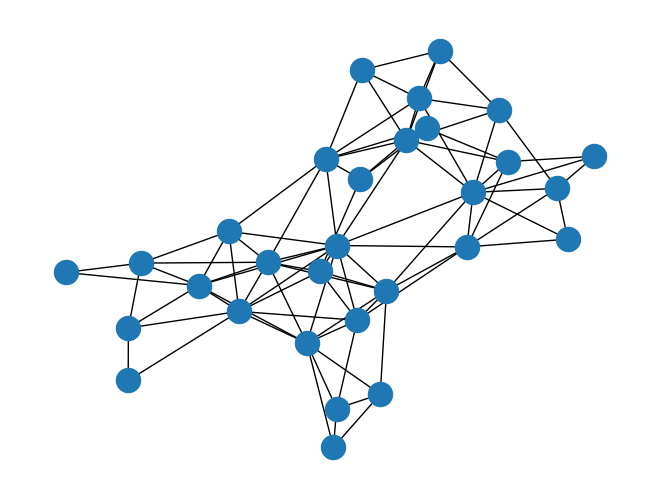

In [8]:
import networkx as nx
g = torch_geometric.utils.to_networkx(X[101], to_undirected=True)
nx.draw(g)

In [139]:
# Save Generated Graphs
torch.save(X, 'graph_list.pt')


# Save each Atoms object into a single .traj file (append mode)
with Trajectory('atoms_list.traj', 'w') as traj:
    for atoms in atoms_list:
        traj.write(atoms)

C:\Users\adamp\AppData\Local\Temp\ipykernel_68912\3134041674.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, x/3-np.log(x))


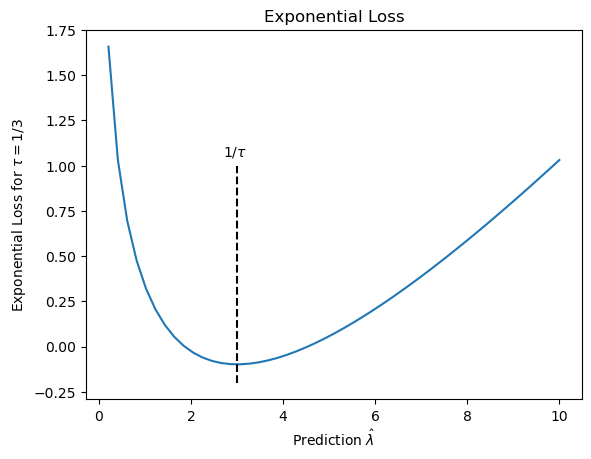

In [173]:
x = np.linspace(0, 10)
plt.plot(x, x/3-np.log(x))
plt.plot([3,3], [-0.2, 1], 'k--')
plt.text(2.7, 1.05, r'1/$\tau$')
plt.ylabel(r'Exponential Loss for $\tau=1/3$')
plt.xlabel(r'Prediction $\hat{\lambda}$')
plt.title("Exponential Loss")
plt.show()

In [ ]:

view(atoms_list[101], viewer='x3d')

In [140]:
"""
from matminer.featurizers.site.bonding import BondOrientationalParameter, AverageBondLength, AverageBondAngle
from matminer.featurizers.site.fingerprint import AGNIFingerprints
from matminer.featurizers.site.rdf import GaussianSymmFunc
from matminer.featurizers.site.chemical import EwaldSiteEnergy, ChemicalSRO, LocalPropertyDifference


    ## Loop through Site featurizers
    property_list = ("Number", "AtomicWeight", "Electronegativity", "CovalentRadius")  # For SiteElementalProperty function
    site_feature_functions = [AGNIFingerprints(cutoff=5, directions=[None])]#, GaussianSymmFunc(cutoff=5), LocalPropertyDifference(properties=property_list), AverageBondLength()]
    # Wishlist: EwaldSiteEnergy(), 
    site_features = {}
    for featurizer in site_feature_functions:
        colnames = featurizer._generate_column_labels(multiindex=False, return_errors=False)
        for i in range(n_idxs): # Atoms
            for j in range(len(jump_idxs[i])): # Jump occurance
                traj_frame = jump_idxs[i][j]
                index = int(el_indexes[i])
                feat = featurizer.featurize(AseAtomsAdaptor.get_structure(traj[traj_frame]), idx=index)
                site_name = "Atom %i Jump %i" % (i, j)
                site_features[site_name].update(dict(zip(colnames, feat)))
                site_features[site_name].update({"Residence Frames" : residence_times[i][j]})

"""

'\nfrom matminer.featurizers.site.bonding import BondOrientationalParameter, AverageBondLength, AverageBondAngle\nfrom matminer.featurizers.site.fingerprint import AGNIFingerprints\nfrom matminer.featurizers.site.rdf import GaussianSymmFunc\nfrom matminer.featurizers.site.chemical import EwaldSiteEnergy, ChemicalSRO, LocalPropertyDifference\n\n\n    ## Loop through Site featurizers\n    property_list = ("Number", "AtomicWeight", "Electronegativity", "CovalentRadius")  # For SiteElementalProperty function\n    site_feature_functions = [AGNIFingerprints(cutoff=5, directions=[None])]#, GaussianSymmFunc(cutoff=5), LocalPropertyDifference(properties=property_list), AverageBondLength()]\n    # Wishlist: EwaldSiteEnergy(), \n    site_features = {}\n    for featurizer in site_feature_functions:\n        colnames = featurizer._generate_column_labels(multiindex=False, return_errors=False)\n        for i in range(n_idxs): # Atoms\n            for j in range(len(jump_idxs[i])): # Jump occurance\n 